In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse,  mean_absolute_percentage_error
import joblib

**Define input data and plot them**

In [2]:
lookback = 10 
test_size = 12
time_step = 1


horizon = 12
n_epochs = 1000

**Read data**

In [3]:
#define input data
data_origin=pd.DataFrame({'y': np.arange(5,255,5)})

data_origin.tail(5)


,y
45,230
46,235
47,240
48,245
49,250


In [4]:
""" # Define the external lambda function for date parsing
date_parser = lambda x: pd.to_datetime(x, format='%d.%m.%Y')

# read data
data_origin = pd.read_csv('input/all_products/01_24/'+file_name, encoding = "utf-8", delimiter=';', parse_dates=[0], date_parser=date_parser)
data_origin.tail(5) """

' # Define the external lambda function for date parsing\ndate_parser = lambda x: pd.to_datetime(x, format=\'%d.%m.%Y\')\n\n# read data\ndata_origin = pd.read_csv(\'input/all_products/01_24/\'+file_name, encoding = "utf-8", delimiter=\';\', parse_dates=[0], date_parser=date_parser)\ndata_origin.tail(5) '

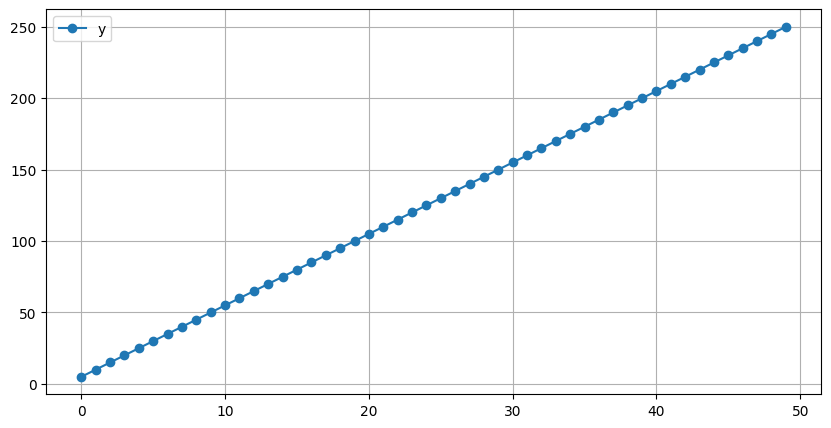

In [5]:
data_origin.plot(figsize=(10,5), marker='o')
plt.grid()
plt.show()

**Scale and parce the data**

In [6]:
#scale data
scaler = MinMaxScaler()
data = scaler.fit_transform(data_origin)

In [7]:
# Function to create input sequences and corresponding output for training
def create_sequences(data, lookback, time_step):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i : i+lookback])
        y.append(data[i+lookback : i+lookback+time_step])
    return np.array(X), np.array(y)

# Create input sequences and corresponding output
X, y = create_sequences(data, lookback, time_step)


In [8]:
# Split the data into training and testing sets
train_size = int(len(X)-test_size)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [9]:
X_train.shape

(28, 10, 1)

In [10]:
X_test.shape

(12, 10, 1)

**Set up model**

In [11]:
#clear previous TensorFlow session
K.clear_session()

#Build the LSTM model
model = Sequential()
model.add(LSTM(40, input_shape=(lookback, 1)))
model.add(Dense(time_step))
model.compile(optimizer='adam', loss='mse')

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 6761 (26.41 KB)
Trainable params: 6761 (26.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Fit and run the model**

In [12]:
#Train the model
history=model.fit(X_train, y_train, 
                  epochs=n_epochs, 
                  batch_size=10, 
                  validation_data=(X_test, y_test), 
                  verbose=0)

#Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")



1/1 [==============================] - 0s 23ms/step - loss: 4.4134e-05
Test Loss: 4.4134289055364206e-05


In [13]:
#define ploting function for loss function

def plot_training(history_dict, y_axis=[0, 1000]):

    plt.plot(history_dict.history['loss'], label='Loss-Training',  c="blue")
    plt.plot(history_dict.history['val_loss'], label='Loss-Test', c="red")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.ylim(y_axis) #limit of the Y-axis

    plt.legend()
    plt.grid(True)

    plt.show()

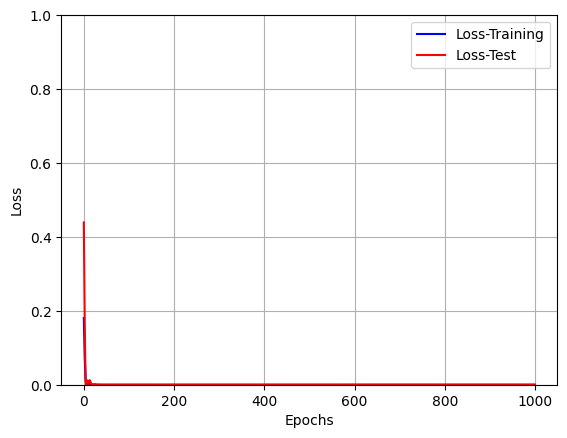

In [14]:
#plot without dropout
plot_training(history,y_axis=[0, 1])

**Predict**

In [15]:
#Predict the next time steps
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 360ms/step


In [16]:
#last prediction=last item of array
y_pred=y_pred.reshape(-1,1)

#scale back
y_pred_trans = scaler.inverse_transform(y_pred)

y_pred_trans

array([[194.68504],
       [199.56071],
       [204.4166 ],
       [209.25166],
       [214.06487],
       [218.85527],
       [223.6219 ],
       [228.3639 ],
       [233.08037],
       [237.77046],
       [242.43346],
       [247.06853]], dtype=float32)

In [17]:
#check if 2D shape
y_pred_trans.shape

(12, 1)

In [18]:
y_test=y_test.reshape(-1,1)

#scale back
y_test_trans = scaler.inverse_transform(y_test)
y_test_trans

array([[195.],
       [200.],
       [205.],
       [210.],
       [215.],
       [220.],
       [225.],
       [230.],
       [235.],
       [240.],
       [245.],
       [250.]])

In [19]:
#check if 2D shape
y_test_trans.shape

(12, 1)

**Plot results**

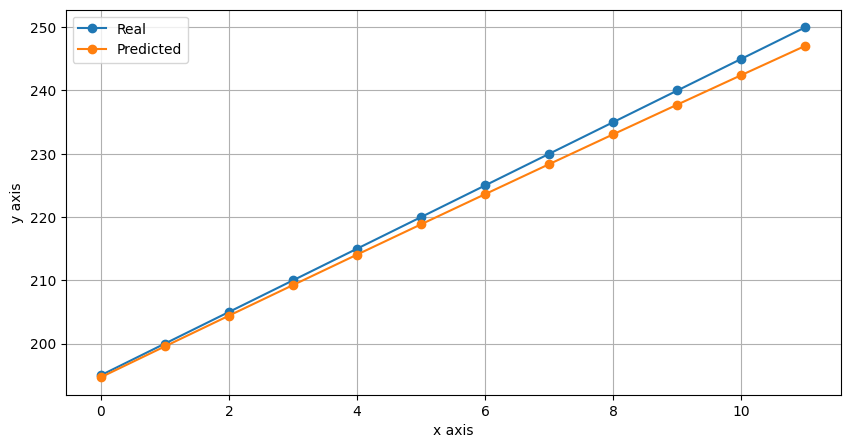

In [20]:
#Plot results for test part

plt.figure(figsize=(10,5))

plt.plot(y_test_trans, label = 'Real', marker='o')
plt.plot(y_pred_trans, label = 'Predicted', marker='o')

plt.grid()
plt.ylabel('y axis')
plt.xlabel('x axis')

plt.legend()
plt.show()

**Evaluate data - RMSE, MAPE**

In [21]:
#calculate root mean squared error
test_score = np.sqrt(mse(y_test_trans, y_pred_trans))

test_score_mape = mean_absolute_percentage_error(y_test_trans, y_pred_trans)

#print results
print(f'RMSE: {round(test_score,2)}')

print(f'MAPE: {round(test_score_mape*100,2)}')


RMSE: 1.63
MAPE: 0.61


**Train on the whole dataset**

In [22]:
#Fit the model on the whole dataset (including test set)
history=model.fit(X,y, epochs=n_epochs, batch_size=10, verbose=0)
final_loss = history.history['loss'][-1]
final_loss

5.778305194326094e-07

## Predict beyond the test set

**Create array**

In [23]:
'''
I must take data from the originally transformed data!!!! Cannot transfor again!!!
'''

'\nI must take data from the originally transformed data!!!! Cannot transfor again!!!\n'

In [24]:
#take data from the test set
last_batch=data[-lookback:]
last_batch

array([[0.81632653],
       [0.83673469],
       [0.85714286],
       [0.87755102],
       [0.89795918],
       [0.91836735],
       [0.93877551],
       [0.95918367],
       [0.97959184],
       [1.        ]])

In [25]:
helping_array = np.full((horizon, 1), np.nan)
helping_array

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

In [26]:
arr = np.concatenate((last_batch, helping_array))
arr

array([[0.81632653],
       [0.83673469],
       [0.85714286],
       [0.87755102],
       [0.89795918],
       [0.91836735],
       [0.93877551],
       [0.95918367],
       [0.97959184],
       [1.        ],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan]])

**Predict**

In [27]:
#define the function for the prediction
def predict_univariate(array, lookback, future_size):
    results=[]

    for i in range(len(array)-lookback):
        
        batch=[]
        batch.append(array[i:i+lookback])
        batch=np.array(batch)
         
        #predict one value
        prediction=model.predict(batch, verbose=0)
    
        #add to the prediction list
        results.append(prediction)

        #replace nan in the array for next iterration
        array[i+lookback] = prediction

    results = array[-future_size:]
        
    return results

In [28]:
#call the function and predict
results = predict_univariate(arr, lookback, horizon)
results

array([[1.01872432],
       [1.03836989],
       [1.05785382],
       [1.07715929],
       [1.09627628],
       [1.1151948 ],
       [1.13390267],
       [1.15238857],
       [1.17064047],
       [1.18864584],
       [1.20639384],
       [1.22391522]])

**Transform results (rows, col)**

In [29]:
results.shape

(12, 1)

In [30]:
""" results=results.reshape(-1,1)
results.shape """

' results=results.reshape(-1,1)\nresults.shape '

In [31]:
#print the results
results_scaled = scaler.inverse_transform(results)
results_scaled

array([[254.58745897],
       [259.40062404],
       [264.1741854 ],
       [268.90402496],
       [273.5876894 ],
       [278.22272539],
       [282.80615389],
       [287.33520031],
       [291.80691481],
       [296.21823072],
       [300.56649029],
       [304.85922873]])

## Label by dates and Display results using - Plotly or Matplotlib

In [96]:
import plotly.graph_objects as go

def plot_chart_interactive(start_date_train, list_train, list_pred, title, freq, plotly=False):
   
   # Check frequency format
   if freq not in ["D", "W-MON", "M"]:
      print(f'Only these options for frequencies are possible: "D", "W-MON", "M" ')
      return None
   
   # Define dates
   start_date_train=str(start_date_train)
   first_date_train = pd.Period(start_date_train, freq=freq)
   first_date_pred = first_date_train + len(list_train)


   # Set up indexes
   if freq=='M':
      train_index = pd.period_range(start=first_date_train, periods=len(list_train), freq='M').strftime('%Y-%m')
      pred_index = pd.period_range(start=first_date_pred, periods=len(list_pred) , freq='M').strftime('%Y-%m')

   elif freq=='D':
      train_index = pd.period_range(start=first_date_train, periods=len(list_train), freq=freq).strftime('%Y-%m-%d')
      pred_index = pd.period_range(start=first_date_pred, periods=len(list_pred) , freq=freq).strftime('%Y-%m-%d')

   elif freq == 'W-MON':
        train_index = pd.period_range(start=first_date_train, periods=len(list_train), freq=freq).strftime('%Y-%m-%d')
        pred_index = pd.period_range(start=first_date_pred, periods=len(list_pred), freq=freq).strftime('%Y-%m-%d')

   
   # Set up a dataframe
   df_train_plot = pd.DataFrame({'True' : list_train}, index=train_index)
   
   df_pred_plot = pd.DataFrame({'Pred' : list_pred}, index=pred_index)

   df_merged = pd.concat([df_train_plot, df_pred_plot], axis=1)


   if plotly==True:
      # Create an interactive scatter plot using Plotly
      fig = go.Figure()

      # Plot the training data
      fig.add_trace(go.Scatter(x=df_merged.index, y=df_merged.iloc[:, 0], mode='lines+markers', name='Train'))

      # Plot the predicted data
      fig.add_trace(go.Scatter(x=df_merged.iloc[-len(list_pred):].index,
                              y=df_merged.iloc[-len(list_pred):, 1],
                              mode='lines+markers',
                              name='Prediction'))

      # Update layout
      fig.update_layout(title=title, 
                        xaxis_title='Date', 
                        yaxis_title='Value', 
                        showlegend=True,
                        height=900, 
                        width=500)
      
      # Display the plot
      fig.show()

   else:
      df_merged.plot(figsize=(10,5), marker='o')
      plt.grid(True)
      plt.show()
     

**Prepare data**

In [69]:
list_pred = results_scaled.flatten().tolist()
list_pred

[254.5874589681625,
 259.40062403678894,
 264.1741853952408,
 268.90402495861053,
 273.58768939971924,
 278.22272539138794,
 282.80615389347076,
 287.3352003097534,
 291.80691480636597,
 296.2182307243347,
 300.56649029254913,
 304.8592287302017]

In [70]:
list_train = data_origin['y'].tolist()
list_train[:5]

[5, 10, 15, 20, 25]

**Display**

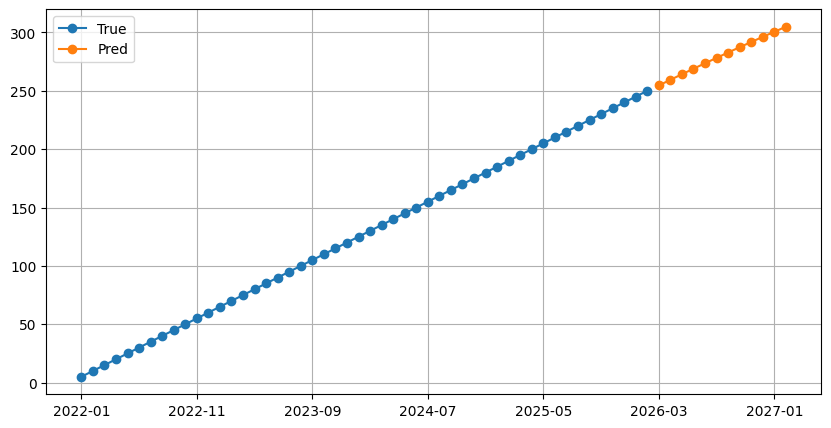

In [97]:
plot_chart_interactive('2022-01-01', list_train, list_pred, 'Train vs Prediction chart', freq='M', plotly=False)